This notebook allows you to visualize exploration and exploitation statistics for the Exploration in Malmo Continuous Mountain Cart EMC^2 experiment. make sure your data is in the run_saves/ folder.

In [33]:
from __future__ import division
import numpy as np
import os
import pylab
import seaborn
import pickle
import scipy.stats as stats
import matplotlib.pyplot as plt

In [75]:
# Step 1 load data
data = pickle.load(open("../logs/test_vizu42.pickle","rb"))
bk = pickle.load(open("../logs/test_vizu42_book_keeping.pickle","rb"))
nb_iter = len(data['observations'])

In [76]:
print "{} iterations loaded: {} arm, {} sound".format(nb_iter,
                                                      bk['nb_motor_it'],
                                                      bk['nb_sound_it'])
print bk.keys()
print len(bk['raw_torso_sounds'])
print data.keys()
for k,v in data.items():
    print 'len {}: {}'.format(k,len(v))

15900 iterations loaded: 1520 arm, 14380 sound
['nb_motor_it', 'nb_sound_it', 'raw_torso_sounds', 'nb_culbuto_pronounced', 'nb_culbuto_touched', 'produced_names', 'nb_culbuto_replaced']
14380
['actions', 'sm_data', 'observations', 'chosen_modules', 'goals']
len actions: 15900
len sm_data: 5
len observations: 15900
len chosen_modules: 15900
len goals: 14400


In [77]:
# Define motor and sensory spaces:
s_hand = range(3, 33)
s_culbuto_1 = range(33, 63)
s_self_sound = range(63, 73)
s_caregiver_sound = range(73, 83)

# Extract relevant observation sub parts
sub_outcomes = {'hand':{'range': s_hand, 'nb_traj_steps': 10},
                'culbuto':{'range': s_culbuto_1, 'nb_traj_steps': 10},
                'agent_sound':{'range': s_self_sound, 'nb_traj_steps': 5},
                'caregiver_sound':{'range': s_caregiver_sound, 'nb_traj_steps': 5}}

for n,d in sub_outcomes.items():
    sub_outcomes[n]['traj'] = []
    sub_outcomes[n]['raw'] = []
    print n
    for i in range(nb_iter):
        sub_outcomes[n]['traj'].append(data['observations'][i][d['range']])
        sub_outcomes[n]['raw'] += np.split(data['observations'][i][d['range']], d['nb_traj_steps'])
    sub_outcomes[n]['raw'] = np.array(sub_outcomes[n]['raw'])
    print len(sub_outcomes[n]['traj'])
    print sub_outcomes[n]['raw'].shape
#print len(np.unique(sub_outcomes['hand']['raw']))

agent_sound
15900
(79500, 2)
caregiver_sound
15900
(79500, 2)
culbuto
15900
(159000, 3)
hand
15900
(159000, 3)


In [78]:
# Compute grid-cell exploration
# Argument:
#   - values: 
print len(np.unique(stats.binned_statistic_dd(sub_outcomes['hand']['raw'],
                                np.arange(len(sub_outcomes['hand']['raw'])),
                                bins = 80,
                                range=[[-1,1],[-1,1],[-1,1]]).binnumber))
print sub_outcomes['culbuto']['raw'].shape

6952
(159000, 3)


In [79]:
nb_runs = 1

# Grid cell exploration curves
metric = ['hand','culbuto','agent_sound','caregiver_sound']
bins = [80,80,100,100]

nb_metrics = len(metric)
plot_every = 100
plot_steps = np.arange(plot_every,((nb_iter // plot_every)+1)*plot_every,plot_every)
print plot_steps

explo = np.zeros((nb_metrics,nb_runs,len(plot_steps)))
for i, plot_idx in enumerate(plot_steps):
    for m_idx, m in enumerate(metric):
            nb_dims = sub_outcomes[m]['raw'].shape[1]
            samples = sub_outcomes[m]['raw'][:plot_idx,:]
            nb_explored_cells = len(np.unique(stats.binned_statistic_dd(samples,
                                                                        np.arange(len(samples)),
                                                                        bins = bins[m_idx],
                                                                        range=[[-1,1]]*nb_dims).binnumber))
            nb_cells = bins[m_idx]**nb_dims
            explo[m_idx,0,i] = (nb_explored_cells / nb_cells)*100
for m_idx, m in enumerate(metric):
    #print m
    #print explo[m_idx,0,:]
mean_explo = np.mean(explo,axis=1)
std_explo = np.std(explo,axis=1)
#print mean_explo.shape


[  100   200   300   400   500   600   700   800   900  1000  1100  1200
  1300  1400  1500  1600  1700  1800  1900  2000  2100  2200  2300  2400
  2500  2600  2700  2800  2900  3000  3100  3200  3300  3400  3500  3600
  3700  3800  3900  4000  4100  4200  4300  4400  4500  4600  4700  4800
  4900  5000  5100  5200  5300  5400  5500  5600  5700  5800  5900  6000
  6100  6200  6300  6400  6500  6600  6700  6800  6900  7000  7100  7200
  7300  7400  7500  7600  7700  7800  7900  8000  8100  8200  8300  8400
  8500  8600  8700  8800  8900  9000  9100  9200  9300  9400  9500  9600
  9700  9800  9900 10000 10100 10200 10300 10400 10500 10600 10700 10800
 10900 11000 11100 11200 11300 11400 11500 11600 11700 11800 11900 12000
 12100 12200 12300 12400 12500 12600 12700 12800 12900 13000 13100 13200
 13300 13400 13500 13600 13700 13800 13900 14000 14100 14200 14300 14400
 14500 14600 14700 14800 14900 15000 15100 15200 15300 15400 15500 15600
 15700 15800 15900]
hand
[1.95312500e-04 1.95312500

agent exploration
hand


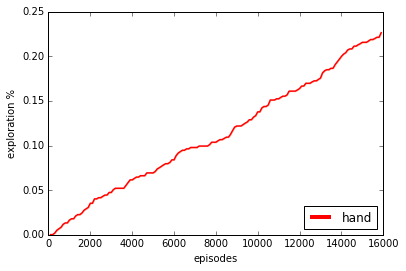

culbuto


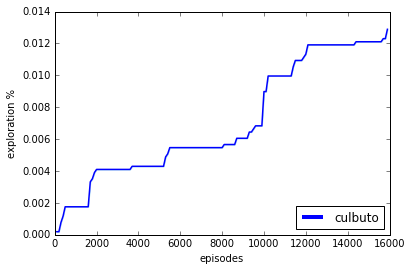

agent_sound


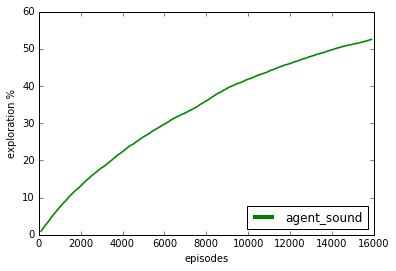

caregiver_sound


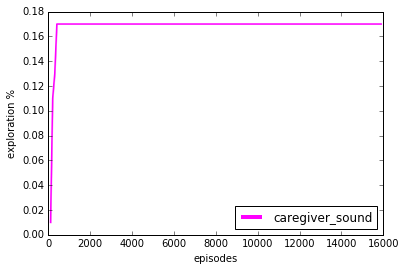

In [80]:
def plot_with_std(x,y,err,color,shade_color,label,y_min=None,y_max=None):
    plt.plot(x,y, color=color, label=label,linewidth=1.5)
    plt.fill_between(x,y-err,y+err,color=shade_color,alpha=0.5)
    leg = plt.legend(loc='lower right')
    for legobj in leg.legendHandles:
        legobj.set_linewidth(4.0)
    plt.xlabel('episodes')
    plt.ylabel('exploration %')
    if y_min is not None:
        plt.ylim(ymin=y_min,ymax=y_max)

colors = ['red','blue','green','magenta','black','cyan','orange']
shades_colors = ['lightsalmon','skyblue','lightgreen','violet']
print "agent exploration"
for i,m in enumerate(metric):
    print m
    y = mean_explo[i,:]
    err = std_explo[i,:]
    plot_with_std(plot_steps,y,err,colors[i],shades_colors[i],metric[i])
    plt.show()
#plt.savefig("dist_agent_pos_expl.pdf", bbox_inches='tight')

In [81]:
import pickle
from rospkg.rospack import RosPack
import rospy
from os.path import join

# Sound config
def compress_sound_traj(sound):
    assert(len(sound) == 100)
    f1s = sound[:50]
    f3s = sound[50:]
    return np.append(f1s[np.array([0, 12, 24, 37, 49])],f3s[np.array([0, 12, 24, 37, 49])])

v_o = list(np.log2([500, 900]))
v_y = list(np.log2([300, 1700]))
v_u = list(np.log2([300, 800]))
v_e = list(np.log2([400, 2200]))
v_i = list(np.log2([300, 2300]))

# Retrieve caregiver sounds and trajectories from json
rospack = RosPack()
with open(join(rospack.get_path('pobax_playground'), 'config', 'human_sounds.pickle')) as f:
    full_human_motor_traj, full_human_sounds_traj  = pickle.load(f)
human_sounds = full_human_sounds_traj.keys()
rospy.loginfo('Voice node using the word %s for culbuto name' % human_sounds[0])

vowels = dict(o=v_o, y=v_y, u=v_u, e=v_e, i=v_i)

human_sounds = ['eyu', 'oey', 'eou', 'oyi']
print "human sounds", human_sounds

human_sounds_traj = dict()
human_sounds_traj_std = dict()
best_vocal_errors = {}
best_vocal_errors_evolution = []
for hs in human_sounds:
    best_vocal_errors[hs] = 10.
    human_sounds_traj[hs] = compress_sound_traj(full_human_sounds_traj[hs])
    human_sounds_traj_std[hs] = [d - 8.5 for d in human_sounds_traj[hs][:5]] + [d - 10.25 for d in human_sounds_traj[hs][5:]]    
        
sound_tol = 0.4   

human sounds ['eyu', 'oey', 'eou', 'oyi']


(array([ 8.,  6.,  2.,  3.,  7., 21., 44., 55., 42., 41.]),
 array([ 1823. ,  3228.9,  4634.8,  6040.7,  7446.6,  8852.5, 10258.4,
        11664.3, 13070.2, 14476.1, 15882. ]),
 <a list of 10 Patch objects>)

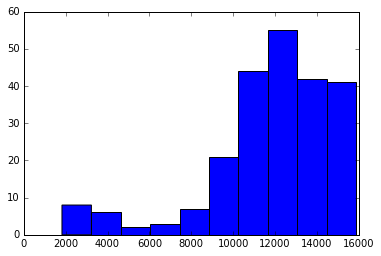

In [82]:
# Plot culbuto name frequency
def analysis_sound(sound):
        #return human_sounds[2]
        #print human_sounds_traj
        for hs in human_sounds:
            #sound = np.array([f[0] for f in diva_traj[[0, 12, 24, 37, 49]]] + [f[1] for f in diva_traj[[0, 12, 24, 37, 49]]])
            error = np.linalg.norm(np.array(human_sounds_traj[hs]) - sound)
            if error < sound_tol:
                #print "***********Agent says", hs
                return hs
        return None

culb_name_said = []
for i,s in enumerate(sub_outcomes['agent_sound']['traj']):
    #denormalize s
    original_s = [d + 8.5 for d in s[:5]] + [d + 10.25 for d in s[5:]]    
    res = analysis_sound(original_s)
    if res == 'eyu':
        culb_name_said.append(i)
plt.hist(culb_name_said)
        